# <Font color = 'indianred'>**Specify Project Folder**

In [1]:
# add lines for autoreload
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys

if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    base_folder = Path('/content/drive/MyDrive/')
    data_folder = Path('/content')

    !pip install pytorch-lightning -U -qq
    !pip install torchmetrics -U -qq
    !pip install fastdownload -U -qq
    !pip install fastai -U

else:
    base_folder = Path('/home/harpreet/Insync/google_drive_shaannoor')
    data_folder = Path('/home/harpreet/data')

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 17.2 MB/s eta 0:00:00


In [3]:
custom_function_folder = base_folder/'data/custom-functions/fall_2023'
sys.path.append(str(custom_function_folder))
model_folder = base_folder/'data/models/dl_fall_2023/dog_breed'
model_folder.mkdir(parents=True, exist_ok=True)
kaggle_api_folder = base_folder/'data/.kaggle'

# <Font color = 'indianred'>**Import Libraries**

In [4]:
import torch
from torchvision import transforms
from pytorch_lightning.loggers import CSVLogger
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.tuner import Tuner ########### NEW ###########


# from local pythion files
from multiclass_lightning_module import MultiClassLightningModule
from data_module_dog_breed import DogBreedDataModule
from mlp_skip_two_layer import MLPSkipTwoLayer
from model_two_layer import TwoLayerMLP
from shared_utils import  plot_losses_acc

# <Font color = 'indianred'>**Setup Trainer**

In [5]:
# Define preprocessing transformations for training and testing datasets
data_transforms = {
    "train": transforms.Compose(
        [
            # Resize the shorter side of the image to (500, 375) pixels
            transforms.Resize((500, 375)),
            # Convert image to PyTorch tensor
            transforms.ToTensor(),
            # Normalize tensor values to range [-1, 1]
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
    "test": transforms.Compose(
        [
            # Resize the shorter side of the image to 640 pixels
            transforms.Resize((500, 375)),
            # Convert image to PyTorch tensor
            transforms.ToTensor(),
            # Normalize tensor values to range [-1, 1]
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
}

In [6]:
# Define the model architecture and training parameters
num_features = 3 * 500 * 375
hidden_dim1 = 500
hidden_dim2 = 500
num_classes = 120
epochs = 5
learning_rate = 0.05
batch_size = 256
log_every_n_steps = 1
fraction_train = 0.8
seed = 42


callbacks = [
    ModelCheckpoint(dirpath=model_folder/'two_layer/version_1', save_top_k=1, mode="max", monitor="val_metric", save_last=True)
]
# Set a random seed for reproducibility
torch.manual_seed(seed)

# Create the neural network model
model = TwoLayerMLP(num_features, hidden_dim1, hidden_dim2, num_classes)

lightning_model = MultiClassLightningModule(model=model,
                                            optimizer_cls= torch.optim.SGD,
                                            loss_fn=torch.nn.CrossEntropyLoss(),
                                            metric_cls=torchmetrics.Accuracy,
                                            num_classes=num_classes,
                                            learning_rate  = learning_rate,
                                            log_every_n_steps=log_every_n_steps,
                                            log_test_metrics=True,
                                            display_metrics=True)

dm = DogBreedDataModule(data_dir=data_folder,
                        kaggle_api_folder=kaggle_api_folder,
                        train_transform=data_transforms["train"],
                        test_transform=data_transforms["test"],
                        batch_size=batch_size,
                        seed=seed,
                        fraction_train=fraction_train,
                        small_subset = True,
                        num_samples_small = 1024)

trainer = pl.Trainer(
        callbacks=callbacks,
        max_epochs=epochs,
        accelerator="auto",  # set to "auto" or "gpu" to use GPUs if available
        devices= 'auto',  # Uses all available GPUs if applicable
        deterministic=True,
        log_every_n_steps = log_every_n_steps,
        logger=CSVLogger(save_dir=model_folder/'logs', name="two_layer")
    )


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [7]:
print([type(cb).__name__ for cb in trainer.callbacks])

['TQDMProgressBar', 'ModelSummary', 'ModelCheckpoint']


# <Font color = 'indianred'>**New: Batch Size and Learning Rate Finder**

In [8]:
########## NEW HERE ############
# Create a Tuner
tuner = Tuner(trainer)

In [ ]:
# tuner.scale_batch_size??

In [9]:
tuner.scale_batch_size(lightning_model,datamodule=dm, mode="binsearch", init_val=64, batch_arg_name="batch_size", steps_per_trial=1)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1: Val_Loss: 4.78, Val_Metric: 0.00 | 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:Batch size 64 succeeded, trying batch size 128


Train_Loss: 4.79, Train_Metric: 0.00
Epoch 1: Val_Loss: 4.77, Val_Metric: 0.00 | 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:Batch size 128 succeeded, trying batch size 256


Train_Loss: 4.74, Train_Metric: 0.06
Epoch 1: Val_Loss: 4.76, Val_Metric: 0.02 | 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:Batch size 256 succeeded, trying batch size 512


Train_Loss: 4.69, Train_Metric: 0.11
Epoch 1: Val_Loss: 4.79, Val_Metric: 0.02 | 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:Batch size 512 succeeded, trying batch size 1024


Train_Loss: 4.54, Train_Metric: 0.12
Epoch 1: Val_Loss: 4.80, Val_Metric: 0.02 | Epoch 1: Val_Loss: 4.78, Val_Metric: 0.02 | 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:The batch size 1024 is greater or equal than the length of your dataset.


Train_Loss: 4.39, Train_Metric: 0.17


INFO:pytorch_lightning.tuner.batch_size_scaling:Finished batch size finder, will continue with full run using batch size 1024
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.scale_batch_size_2a3ca30e-dab6-49fe-8b49-30624662bdc8.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.scale_batch_size_2a3ca30e-dab6-49fe-8b49-30624662bdc8.ckpt


1024

In [10]:
dm.batch_size

1024

In [11]:
import numpy as np

def linear_lr(min_lr, max_lr, num_steps):
    return np.linspace(min_lr, max_lr, num_steps)

def exponential_lr(min_lr, max_lr, num_steps):
    return min_lr * (max_lr / min_lr) ** (np.linspace(0, 1, num_steps))


In [12]:
# Usage example:
num_steps = 10
min_lr = 0.0001
max_lr = 1

linear_rates = linear_lr(min_lr, max_lr, num_steps)
exponential_rates = exponential_lr(min_lr, max_lr, num_steps)
print(linear_rates)
print(exponential_rates)

[1.000e-04 1.112e-01 2.223e-01 3.334e-01 4.445e-01 5.556e-01 6.667e-01
 7.778e-01 8.889e-01 1.000e+00]
[1.00000000e-04 2.78255940e-04 7.74263683e-04 2.15443469e-03
 5.99484250e-03 1.66810054e-02 4.64158883e-02 1.29154967e-01
 3.59381366e-01 1.00000000e+00]


In [ ]:
# tuner.lr_find??

In [13]:
# finds learning rate automatically
dm.batch_size = 256
lr_finder = tuner.lr_find(lightning_model, datamodule=dm, min_lr=0.001, max_lr=10, num_training=30, mode='exponential')



INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1: Val_Loss: 4.79, Val_Metric: 0.01 | 

Finding best initial lr:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: Val_Loss: 4.78, Val_Metric: 0.01 | Train_Loss: 4.79, Train_Metric: 0.00
Epoch 2: Val_Loss: 4.77, Val_Metric: 0.01 | Train_Loss: 4.76, Train_Metric: 0.02
Epoch 3: Val_Loss: 4.77, Val_Metric: 0.01 | Train_Loss: 4.69, Train_Metric: 0.05
Epoch 4: Val_Loss: 5.03, Val_Metric: 0.02 | Train_Loss: 4.61, Train_Metric: 0.09
Epoch 5: Val_Loss: 890.36, Val_Metric: 0.01 | 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.tuner.lr_finder:LR finder stopped early after 20 steps due to diverging loss.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.054116952654646375
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_1e82c97f-f409-4883-9221-7f24c5039672.ckpt


Train_Loss: 9.72, Train_Metric: 0.04


INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_1e82c97f-f409-4883-9221-7f24c5039672.ckpt


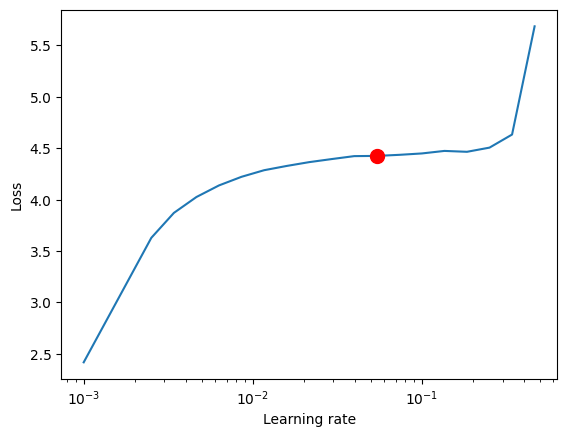

In [14]:
fig = lr_finder.plot(suggest=True)

In [15]:
import pandas as pd
pd.DataFrame(lr_finder.results)

,lr,loss
0,0.001000,2.418277
1,0.001848,3.224911
2,0.002512,3.628526
3,0.003415,3.870614
4,0.004642,4.024991
5,0.006310,4.137612
6,0.008577,4.221384
7,0.011659,4.285390
8,0.015849,4.326779
9,0.021544,4.363965


In [16]:
# get suggestion
new_lr = lr_finder.suggestion()
print(new_lr)

0.054116952654646375


In [17]:
lightning_model.learning_rate = new_lr
dm.batch_size = 1024

In [18]:
trainer.fit(lightning_model, dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | TwoLayerMLP        | 281 M 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
----------------------------------------------------
281 M     Trainable params
0         Non-trainable params
281 M     Total params
1,126.244 Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 4.79, Val_Metric: 0.01 | 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 4.78, Val_Metric: 0.01 | Train_Loss: 4.79, Train_Metric: 0.00


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 4.76, Val_Metric: 0.01 | Train_Loss: 4.68, Train_Metric: 0.07


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 4.76, Val_Metric: 0.01 | Train_Loss: 4.54, Train_Metric: 0.15


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 4.76, Val_Metric: 0.02 | Train_Loss: 4.39, Train_Metric: 0.24


Validation: 0it [00:00, ?it/s]

Epoch 5: Val_Loss: 4.76, Val_Metric: 0.02 | Train_Loss: 4.23, Train_Metric: 0.27


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


# <Font color = 'indianred'>**Plot Losses**

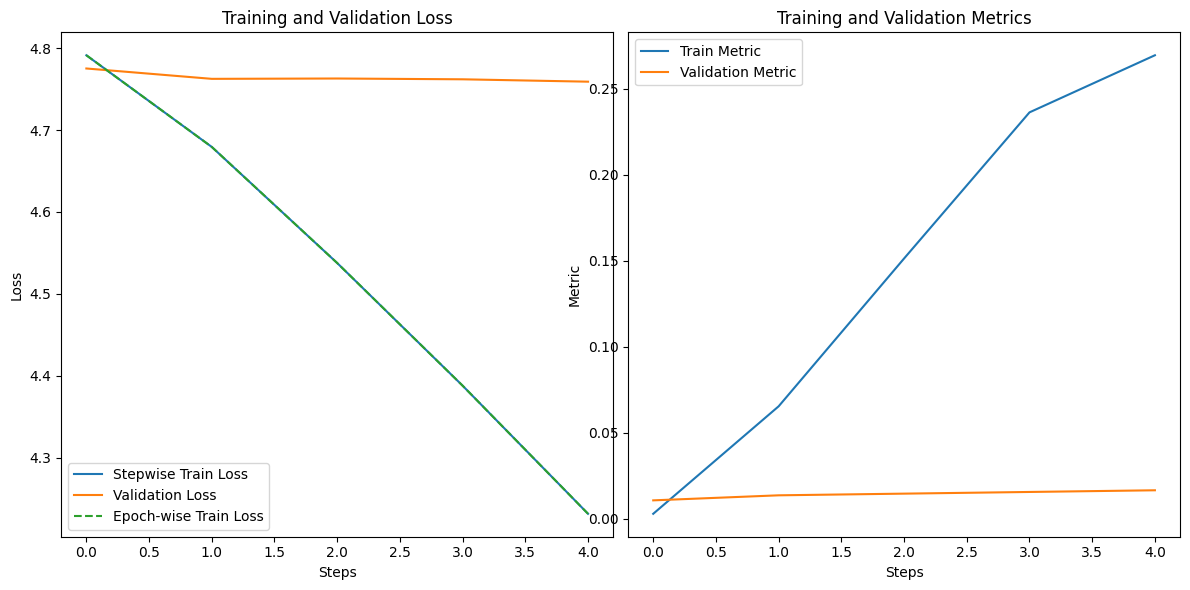

In [19]:
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)


# <Font color = 'indianred'>**Save Model**

In [ ]:
# ckpt_path = trainer.logger.log_dir+ "/model.ckpt"
# print(ckpt_path)
# trainer.save_checkpoint(ckpt_path)

# <Font color = 'indianred'>**Evaluation**

In [20]:
ckpt_path = trainer.checkpoint_callback.best_model_path
ckpt_path

'/content/drive/MyDrive/data/models/dl_fall_2023/dog_breed/two_layer/version_1/epoch=4-step=5.ckpt'

In [21]:
train_acc = trainer.validate(dataloaders=dm.train_dataloader(), ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(), ckpt_path=ckpt_path, verbose=False)
# test_acc = trainer.test(dataloaders=dm.test_dataloader(), ckpt_path=ckpt_path, verbose=False)

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/dog_breed/two_layer/version_1/epoch=4-step=5.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/dog_breed/two_layer/version_1/epoch=4-step=5.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 4.08, Val_Metric: 0.34 | 

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/dog_breed/two_layer/version_1/epoch=4-step=5.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/dog_breed/two_layer/version_1/epoch=4-step=5.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 4.76, Val_Metric: 0.02 | 

In [22]:
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
# print(f"Test Accuracy: {test_acc[0]['test_metric']*100:0.2f}")

Train Accuracy: 34.28
Validation Accuracy: 1.66
